<a href="https://colab.research.google.com/github/ivanadj3/MIEP/blob/main/MIASCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: Mountpoint must not already contain files

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
img_height, img_width = 224, 224
batch_size = 16
num_classes = 4

In [ ]:
dataset_dir = '/content/drive/MyDrive/MIAS/all-mias'
output_dir = '/content/drive/MyDrive/MIAS/all-mias_processed'

In [ ]:
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Kreiranje poddirektorijuma za svaku klasu

classes = ['A', 'B', 'C', 'D']
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Listanje i etiketiranje fajlova

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])

        if file_number % 4 == 0:
            class_label = 'A'
        elif file_number % 4 == 1:
            class_label = 'B'
        elif file_number % 4 == 2:
            class_label = 'C'
        else:
            class_label = 'D'

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

In [ ]:
import shutil

train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Kopiranje fajlova u odgovarajuće foldere

for file, label in zip(train_files, train_labels):
    dst = os.path.join(train_dir, label, os.path.basename(file))
    shutil.copyfile(file, dst)

for file, label in zip(test_files, test_labels):
    dst = os.path.join(test_dir, label, os.path.basename(file))
    shutil.copyfile(file, dst)

print("Slike su uspešno podeljene i kopirane u odgovarajuće direktorijume.")

Slike su uspešno podeljene i kopirane u odgovarajuće direktorijume.


In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input


def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        os.makedirs(os.path.join(output_directory, label), exist_ok=True)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model_v2.keras', save_best_only=True),
    reduce_lr
]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


In [ ]:
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.2522 - loss: 2.6668 - val_accuracy: 0.2344 - val_loss: 2.6304 - learning_rate: 1.0000e-04
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2500 - loss: 2.6491 - val_accuracy: 0.0000e+00 - val_loss: 2.6858 - learning_rate: 1.0000e-04
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.2237 - loss: 2.6610 - val_accuracy: 0.2500 - val_loss: 2.6138 - learning_rate: 1.0000e-04
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3750 - loss: 2.6032 - val_accuracy: 0.0000e+00 - val_loss: 2.7024 - learning_rate: 1.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.2465 - loss: 2.6603 - val_accuracy: 0.2500 - val_loss: 2.5993 - learning_rate: 1.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3125 - loss: 2.5786 - val_accuracy: 0.0000e+00 - val_loss: 2.5278 - learning_rate: 1.0000e-04
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG16
import itertools

img_height, img_width = 224, 224
batch_size = 16
num_classes = 4

dataset_dir = '/content/drive/MyDrive/MIAS/all-mias'
output_dir = '/content/drive/MyDrive/MIAS/all-mias_processed'


train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['A', 'B', 'C', 'D']

def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Definisanje modela sa unapred treniranim VGG16 modelom
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

base_model.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model_v2.keras', save_best_only=True),
    reduce_lr
]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
print(f'Validation samples: {validation_generator.samples}')

Validation samples: 65


In [ ]:
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 182s 11s/step - accuracy: 0.2635 - loss: 1.6743 - val_accuracy: 0.2344 - val_loss: 1.4671 - learning_rate: 1.0000e-04
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.2500 - loss: 1.7725 - val_accuracy: 1.0000 - val_loss: 0.9264 - learning_rate: 1.0000e-04
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 210s 11s/step - accuracy: 0.2189 - loss: 1.6482 - val_accuracy: 0.2656 - val_loss: 1.4208 - learning_rate: 1.0000e-04
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.3125 - loss: 1.4465 - val_accuracy: 0.0000e+00 - val_loss: 1.4782 - learning_rate: 1.0000e-04
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 198s 12s/step - accuracy: 0.2403 - loss: 1.5445 - val_accuracy: 0.1719 - val_loss: 1.4581 - learning_rate: 1.0000e-04
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.3125 - loss: 1.3423 - val_accuracy: 1.0000 - val_loss: 1.1244 - learning_rate: 2.0000e-05
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 190s 11s/step - accuracy

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG16
import itertools
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

img_height, img_width = 224, 224
batch_size = 16
num_classes = 4

dataset_dir = '/content/drive/MyDrive/MIAS/all-mias'
output_dir = '/content/drive/MyDrive/MIAS/all-mias_processed'


train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['A', 'B', 'C', 'D']

def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

base_model.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model_v2.keras', save_best_only=True)
]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.3059 - loss: 1.7281 - val_accuracy: 0.2188 - val_loss: 1.4196 - learning_rate: 1.0000e-04
Epoch 2/15
 1/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.1250 - loss: 1.7079

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.1250 - loss: 1.7079 - val_accuracy: 0.0000e+00 - val_loss: 1.4150 - learning_rate: 1.0000e-04
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.2877 - loss: 1.5851 - val_accuracy: 0.2500 - val_loss: 1.3954 - learning_rate: 1.0000e-04
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.0000e+00 - loss: 2.6207 - val_accuracy: 1.0000 - val_loss: 1.2209 - learning_rate: 1.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.2762 - loss: 1.5766 - val_accuracy: 0.2344 - val_loss: 1.4004 - learning_rate: 1.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1250 - loss: 1.7202 - val_accuracy: 0.0000e+00 - val_loss: 1.4047 - learning_rate: 1.0000e-04
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.2410 - loss: 1.6115 - val_accuracy: 0.2500 - val_loss: 1.3958 - learning_rate: 1.0000e-04
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.1875

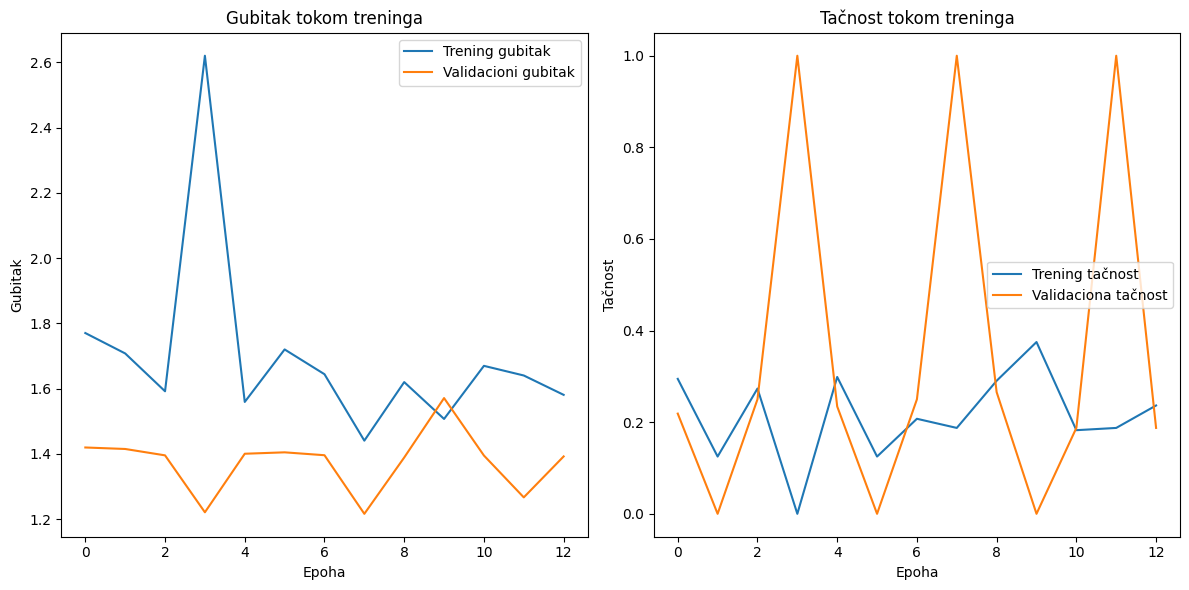

In [ ]:
def plot_training(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Trening gubitak')
    plt.plot(history.history['val_loss'], label='Validacioni gubitak')
    plt.xlabel('Epoha')
    plt.ylabel('Gubitak')
    plt.title('Gubitak tokom treninga')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Trening tačnost')
    plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Tačnost tokom treninga')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

img_height, img_width = 224, 224
batch_size = 16
num_classes = 4

dataset_dir = '/content/drive/MyDrive/MIAS/all-mias'
output_dir = '/content/drive/MyDrive/MIAS/all-mias_processed'

train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['A', 'B', 'C', 'D']

def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model_v2.keras', save_best_only=True),
    reduce_lr
]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2419 - loss: 1.4095 - val_accuracy: 0.3125 - val_loss: 1.3856 - learning_rate: 1.0000e-04
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.3750 - loss: 1.3752 - val_accuracy: 0.0000e+00 - val_loss: 1.3561 - learning_rate: 1.0000e-04
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2054 - loss: 1.4003 - val_accuracy: 0.2500 - val_loss: 1.3925 - learning_rate: 1.0000e-04
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 319ms/step - accuracy: 0.2500 - loss: 1.3956 - val_accuracy: 0.0000e+00 - val_loss: 1.4212 - learning_rate: 1.0000e-04
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.2815 - loss: 1.3881 - val_accuracy: 0.2500 - val_loss: 1.3955 - learning_rate: 1.0000e-04
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2500 - loss: 1.3539 - val_accuracy: 0.0000e+00 - val_loss: 1.5282 - learning_rate: 2.0000e-05
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy

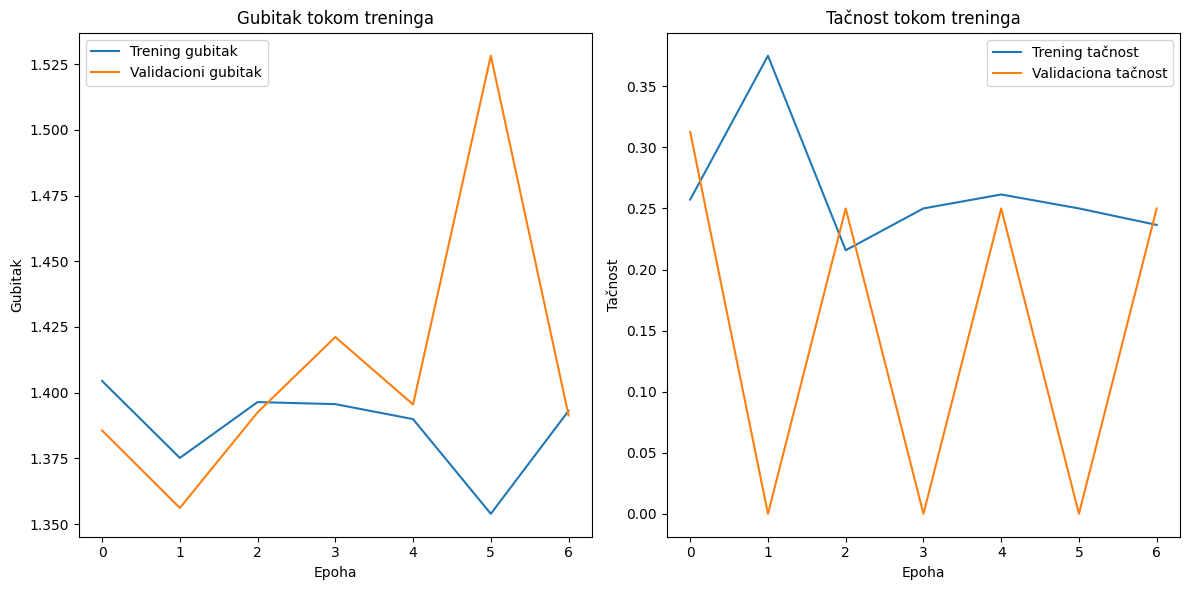

In [ ]:
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=callbacks
)

def plot_training(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Trening gubitak')
    plt.plot(history.history['val_loss'], label='Validacioni gubitak')
    plt.xlabel('Epoha')
    plt.ylabel('Gubitak')
    plt.title('Gubitak tokom treninga')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Trening tačnost')
    plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Tačnost tokom treninga')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

Dodavanje class weights

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

img_height, img_width = 224, 224
batch_size = 8 # REDUCING BATCH SIZE
num_classes = 4

dataset_dir = '/content/drive/MyDrive/MIAS/all-mias'
output_dir = '/content/drive/MyDrive/MIAS/all-mias_processed'

train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['A', 'B', 'C', 'D']

def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer = Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy']) # LOWER LEARNING RATE

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model_v2.keras', save_best_only=True),
]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2219 - loss: 1.3866 - val_accuracy: 0.2500 - val_loss: 1.3861 - learning_rate: 8.0000e-06
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2500 - loss: 1.3867 - val_accuracy: 0.0000e+00 - val_loss: 1.3817 - learning_rate: 8.0000e-06
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2439 - loss: 1.3860 - val_accuracy: 0.2500 - val_loss: 1.3858 - learning_rate: 8.0000e-06
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2500 - loss: 1.3851 - val_accuracy: 0.0000e+00 - val_loss: 1.3951 - learning_rate: 8.0000e-06
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2435 - loss: 1.3876 - val_accuracy: 0.2344 - val_loss: 1.3863 - learning_rate: 8.0000e-06
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2500 - loss: 1.3945 - val_accuracy: 1.0000 - val_loss: 1.3672 - learning_rate: 1.6000e-06
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.258

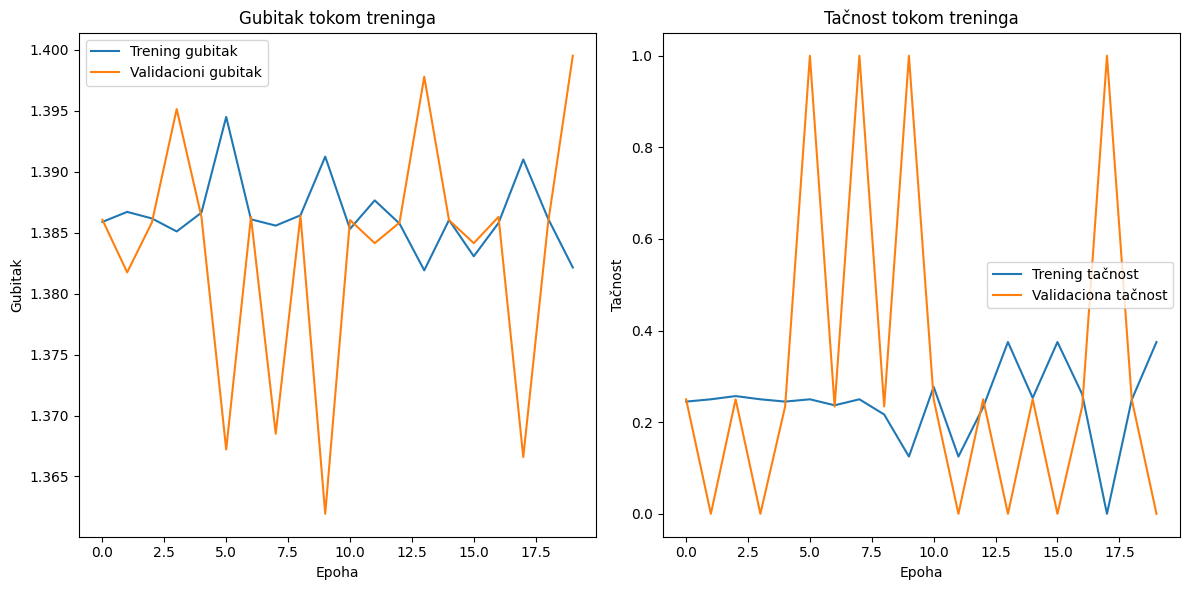

In [ ]:
#steps_per_epoch = len(train_generator)
#validation_steps = len(validation_generator)

steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[reduce_lr]
)

def plot_training(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Trening gubitak')
    plt.plot(history.history['val_loss'], label='Validacioni gubitak')
    plt.xlabel('Epoha')
    plt.ylabel('Gubitak')
    plt.title('Gubitak tokom treninga')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Trening tačnost')
    plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Tačnost tokom treninga')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

...

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

img_height, img_width = 224, 224
batch_size = 8 # REDUCING BATCH SIZE
num_classes = 4

dataset_dir = '/content/drive/MyDrive/MIAS/all-mias'
output_dir = '/content/drive/MyDrive/MIAS/all-mias_processed'

train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['A', 'B', 'C', 'D']

def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=1e-5, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model_v2.keras', save_best_only=True),
]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2475 - loss: 1.3849 - val_accuracy: 0.3125 - val_loss: 1.3867 - learning_rate: 1.0000e-05
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2661 - loss: 1.3830 - val_accuracy: 1.0000 - val_loss: 1.3529 - learning_rate: 1.0000e-05
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.1250 - loss: 1.3900 - val_accuracy: 0.3125 - val_loss: 1.3851 - learning_rate: 1.0000e-05
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2393 - loss: 1.3881 - val_accuracy: 1.0000 - val_loss: 1.3759 - learning_rate: 1.0000e-05
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2740 - loss: 1.3872 - val_accuracy: 0.3594 - val_loss: 1.3841 - learning_rate: 1.0000e-05
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2500 - loss: 1.3841 - val_accuracy: 0.0000e+00 - val_loss: 1.3861 - learning_rate: 2.0000e-06
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.1702 - loss: 1.3899 - val_accuracy: 0.3906 - val_loss: 1.3842 - learning_rate: 2.0000e-06
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2064 - loss: 1.3843 - val_accuracy: 1.0000 - val_loss: 1.3733 - learning_rate: 2.0000e-06
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.0000e+00 - loss

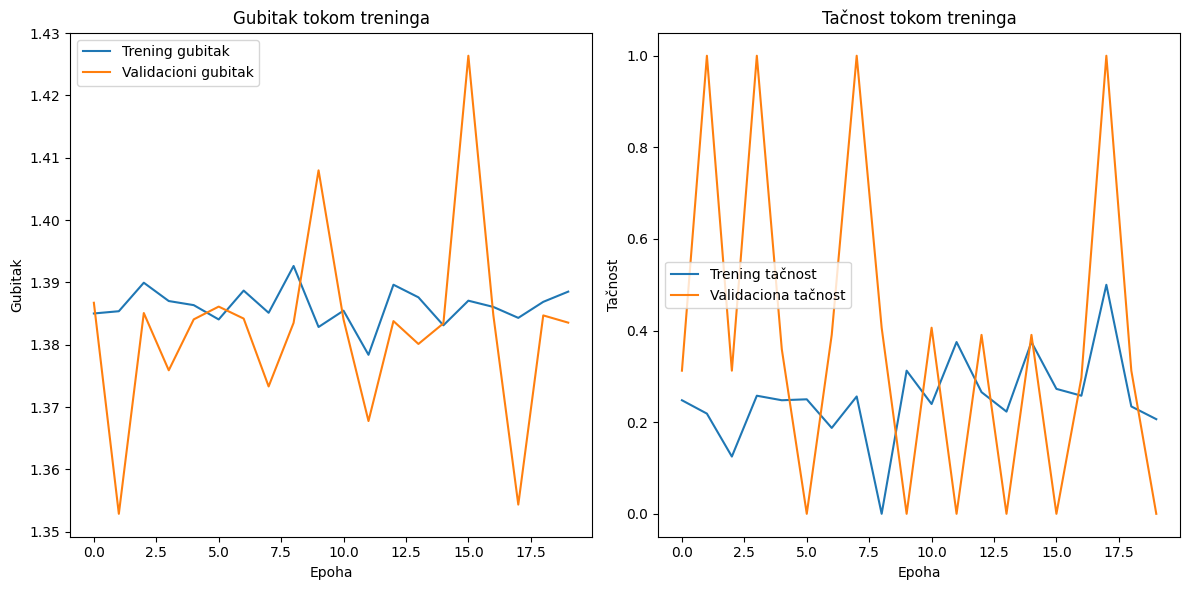

In [ ]:
steps_per_epoch = len(train_generator) // 2
validation_steps = validation_generator.samples // batch_size

class_weights = {
    0: 1.0,  # Class 'A' weight
    1: 1.5,  # Class 'B' weight
    2: 2.0,  # Class 'C' weight
    3: 1.0   # Class 'D' weight
}

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[reduce_lr]  # Use learning rate scheduler
)
# Plotting the training progress
plot_training(history)

AdaDelta Optimizer:

In [ ]:
from google.colab import drive
drive.flush_and_unmount()  # Unmounts the drive

Drive not mounted, so nothing to flush and unmount.
